Here we will use [**A Million News Headlines**](https://www.kaggle.com/therohk/million-headlines) 

# Imports

In [1]:
import pandas as pd
pd.set_option('display.max_columns', None)# to print all columns
import nltk
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize 
from nltk.stem import PorterStemmer
from sklearn.decomposition import LatentDirichletAllocation, TruncatedSVD
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import GridSearchCV
import gensim
import gensim.corpora as corpora
from gensim.models import CoherenceModel
from pprint import pprint
import matplotlib.pyplot as plt

import time
import numpy as np
nltk.download('stopwords')
nltk.download('punkt')
stop_words = set(stopwords.words('english')) 
porter=PorterStemmer()

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Zunair\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Zunair\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


# Explore Data

In [2]:
# extract zip file
#unzip million-headlines.zip

In [3]:
# read csv file using pandas
data = pd.read_csv('D:\\7085\\dataset.csv')

In [84]:
#print first five rows
data.head()

#Import the wordcloud library
#from wordcloud import WordCloud
# Join the different processed titles together.
#long_string = ','.join(list(data['headline_text'].values))
# Create a WordCloud object
#wordcloud = WordCloud(background_color="white", max_words=5000, contour_width=5, contour_color='grey')
# Generate a word cloud
#wordcloud.generate(long_string)
# Visualize the word cloud
#wordcloud.to_image()



,headline_text,processed_headline_text,tokenize_text
0,aba decides against community broadcasting lic...,aba decid commun broadcast licenc,"[aba, decid, commun, broadcast, licenc]"
1,act fire witnesses must be aware of defamation,act fire wit must awar defam,"[act, fire, wit, must, awar, defam]"
2,a g calls for infrastructure protection summit,g call infrastructur protect summit,"[g, call, infrastructur, protect, summit]"
3,air nz staff in aust strike for pay rise,air nz staff aust strike pay rise,"[air, nz, staff, aust, strike, pay, rise]"
4,air nz strike to affect australian travellers,air nz strike affect australian travel,"[air, nz, strike, affect, australian, travel]"


**Here we have two columns 1. publish_date  2.headline_text** <br>
**For our task we need only headline_text column we will remove publish_date**

In [5]:
#drop method wll delete column from dataframe 
#axis=1 means column
data = data.drop(['publish_date'],axis=1)

In [6]:
# get how many rows we have
num_rows = data.shape[0]
print("we have total {} number of rows".format(num_rows))

we have total 1186018 number of rows


In [7]:
#check is there any null value or not
# isnull() method will return boolean value true for null else false
# sum method will calculate how many true values 
data['headline_text'].isnull().sum()

0

**Here we don't have any null value**

In [8]:
#check for duplicate value
duplicate_data = data[data.duplicated()]

In [9]:
print("here we have total {} duplicate rows".format(duplicate_data.shape[0]))

here we have total 30180 duplicate rows


In [10]:
#let remove duplicate rows
#drop_duplicates method will remove each duplicate row by keeping first occurence of row
data = data.drop_duplicates()

In [11]:
print("After removing duplicate row we haev {} number of rows in dataset".
      format(data.shape[0]))

After removing duplicate row we haev 1155838 number of rows in dataset


# Pre-process data

In [12]:
def process_text(text):
  """ 
    this method will process text by performing follwing operations
    1. convert text into lower 
    2. remove special characters
    3. remove stop words 
    4. stemming word
  
    Parameters: 
    arg1 (text): string
  
    Returns: 
    list: processed words
  
    """
  #convert text into lower case
  text = text.lower()

  #remove special characters
  # re.sub will replace all character with '' except a-z and 0-9
  text = re.sub('[^a-z0-9 ]+', '', text) 

  #remove stop words
  word_tokens = word_tokenize(text) #convert sentence into words
  
  processed_text = [porter.stem(word) for word in word_tokens
                    if not word in stop_words] 

  
  processed_text = " ".join(processed_text)
  
  return processed_text



In [13]:
data['processed_headline_text'] = data['headline_text'].apply(process_text)

In [14]:
data.head()

,headline_text,processed_headline_text
0,aba decides against community broadcasting lic...,aba decid commun broadcast licenc
1,act fire witnesses must be aware of defamation,act fire wit must awar defam
2,a g calls for infrastructure protection summit,g call infrastructur protect summit
3,air nz staff in aust strike for pay rise,air nz staff aust strike pay rise
4,air nz strike to affect australian travellers,air nz strike affect australian travel


**The LDA topic model algorithm requires a document word matrix as the main input.**<br>
* **A document-word matrix is a mathematical matrix that describes the frequency<br> of word that occur in a documents. In a document-word matrix, rows correspond<br> to documents and columns correspond to words**

* **To create document-word matrix we use Countvectorizer**

In [15]:
# min_df : ignore words that have a document frequency strictly lower than the given min_df value
#lowercase: we specify lowercase = False as we already done in per-processing
# max_df : ignore words that have a document frequency strictly higer than the given max_df value
vectorizer = CountVectorizer(min_df=15,max_df=0.5,lowercase=False) #initialize CountVectorizer


In [16]:
#apply countvectorizer to our data
vectorizer = vectorizer.fit(data['processed_headline_text'])
vectorize_data = vectorizer.transform(data['processed_headline_text'])

# Build LDA model 

In [17]:
# learning_methon = online, is faster
lda_model = LatentDirichletAllocation(n_components=8,          # Number of topics
                                      max_iter=5,              # Max learning iterations
                                      learning_method='online',   
                                      random_state=100,          # Random state
                                      batch_size=128,  # number of docs in each learning iter        
                                     )

In [18]:
# we also calculate time to fit/train model
start = time.time()
lda_output = lda_model.fit_transform(vectorize_data)
end = time.time()

In [19]:
print("total time to train model {} minutes".format((end-start)/60))

total time to train model 10.332113440831503 minutes


In [20]:
# Log Likelyhood: Higher the better
print("Log Likelihood: ", lda_model.score(vectorize_data))

# Perplexity: Lower the better.
# Perplexity = exp(-1. * log-likelihood per word)
print("Perplexity: ", lda_model.perplexity(vectorize_data))

Log Likelihood:  -52379678.42748524
Perplexity:  5398.562374893334


# Check dominant topics in each document

In [21]:
# make topic name as column
# giving topic name as Topic_0,Topic_1,...,Topic_7

topic_names = ["Topic_" + str(i) for i in range(lda_model.n_components)]

#create index as Doc_0,Doc_1...
document_names = ["Doc_" + str(i) for i in range(len(data))]


# create the pandas dataframe
# columns = topic_names
# index = document_names
# we are rounding lda output upto 2 precision for better visibility 
dataframe_topic = pd.DataFrame(np.round(lda_output, 2),
                               columns=topic_names,
                               index=document_names)


# create new column dominant_topic
# for this we take argmax which will return index of column which has higest value
# here column is topics
dominant_topic = np.argmax(dataframe_topic.values, axis=1)
dataframe_topic['dominant_topic'] = dominant_topic

print(dataframe_topic.head(10))


       Topic_0  Topic_1  Topic_2  Topic_3  Topic_4  Topic_5  Topic_6  Topic_7  \
Doc_0     0.02     0.02     0.02     0.02     0.19     0.69     0.02     0.02   
Doc_1     0.02     0.02     0.87     0.02     0.02     0.02     0.02     0.02   
Doc_2     0.03     0.22     0.03     0.23     0.03     0.42     0.03     0.03   
Doc_3     0.77     0.14     0.02     0.02     0.02     0.02     0.02     0.02   
Doc_4     0.87     0.02     0.02     0.02     0.02     0.02     0.02     0.02   
Doc_5     0.03     0.03     0.03     0.03     0.03     0.62     0.23     0.03   
Doc_6     0.02     0.02     0.02     0.02     0.02     0.02     0.02     0.85   
Doc_7     0.75     0.02     0.15     0.02     0.02     0.02     0.02     0.02   
Doc_8     0.02     0.59     0.02     0.30     0.02     0.02     0.02     0.02   
Doc_9     0.02     0.19     0.02     0.02     0.52     0.19     0.02     0.02   

       dominant_topic  
Doc_0               5  
Doc_1               2  
Doc_2               5  
Doc_3       

* **Here we can see that doc_0 has topic 5 as dominant topic with 0.69 weight and so on...**

# check distribution of topic in whole data

In [22]:
# for printing topic distribution 
# we use value counts on dominant_topic column which return number of document for each topic


topic_distribution = dataframe_topic['dominant_topic'].value_counts()

print(topic_distribution)

0    256113
1    161226
2    157903
3    136856
4    126112
5    117001
6    101477
7     99150
Name: dominant_topic, dtype: int64


* **here we can see distribution of topics<br>256112 documents belongs to topic_0<br>161226 documents belongs to topic_1 <br>and so on**

# Predict topic for new documnet

In [23]:
new_text = "christmas is detention centre no go claims quashed"

preprocessed_text = process_text(new_text) # process
vectorize_text = vectorizer.transform([preprocessed_text]) #convert into vector

prediction = lda_model.transform(vectorize_text) #will return weight for each topic

In [24]:
for index,weight in enumerate(prediction[0]):
  print('Topic_{} * {}'.format(index,weight))

Topic_0 * 0.01785714288042186
Topic_1 * 0.017857142884852902
Topic_2 * 0.4463937999316188
Topic_3 * 0.017857142883393556
Topic_4 * 0.017891749086458606
Topic_5 * 0.017857142881110545
Topic_6 * 0.16071432768456242
Topic_7 * 0.3035715517675813


* **Here max weight for topic_2 so dominant topic is topic_2**

# Save model

In [25]:
#save models
import pickle

pickle.dump(vectorizer, open("D:/7085/cw1/Countvectorizer.pickle", "wb"))

pickle.dump(lda_model, open("D:/7085/cw1/LDA.pickle", "wb"))

**perplexity might not be the best measurement to evaluate topic models As it doesn’t consider the context and semantic associations between words. fot this we have to use topic coherence**
**Sklearn doesn't support topic coherence and it is taking too much time. so we decide to move on gensim library with 50% dataset**

# Gensim

**For gensim we have to convert our processed text into list of tokens**

In [26]:
#for tokenize word we simply split processed text at space
data['tokenize_text'] = data['processed_headline_text'].apply(lambda t : t.split(" "))

In [27]:
data_50 = data.sample(frac=0.5)

In [28]:
data_50.shape

(577919, 3)

**We need dictionary and corpus for topic modeling using gensim**

In [29]:
# Create Dictionary
id_to_word = corpora.Dictionary(data_50['tokenize_text'])

# Create Corpus
texts = data_50['tokenize_text']

# Term Document Frequency
corpus = [id_to_word.doc2bow(text) for text in texts]

In [30]:
print(corpus[:2])

[[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1)], [(5, 1), (6, 1), (7, 1), (8, 1)]]


**gensim will create unique id for each word**

**We can print word cooresponding each id using id_to_word**

In [31]:
print(id_to_word[4])

tiger


# Build LDA using Gensim

In [32]:
# Build LDA model
#chunksize :  number of document use in each training iteration
#passes : number of passes/iteration for training
# num_topics : number of topics for topic modeling
# here alpha and eta are hyper parameter which affect sparsity of model we are leaving them default value

start_gensim_lda = time.time()
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id_to_word,
                                           num_topics=10, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=10000, # number of document use in each training iteration
                                           passes=10,
                                           per_word_topics=True)
end_gensim_lda = time.time()

In [33]:
print("time to buld one LDA model using gensim : {} minutes".
      format((end_gensim_lda-start_gensim_lda)/60))

time to buld one LDA model using gensim : 12.27612022558848 minutes


**we can print the keywords for each topic and the weightage(of each keyword using lda_model.print_topics()**

In [34]:
pprint(lda_model.print_topics())


[(0,
  '0.037*"fire" + 0.024*"hous" + 0.014*"interview" + 0.011*"warn" + '
  '0.010*"action" + 0.010*"cost" + 0.010*"bushfir" + 0.009*"return" + '
  '0.009*"home" + 0.008*"green"'),
 (1,
  '0.022*"council" + 0.020*"plan" + 0.017*"govt" + 0.016*"urg" + 0.014*"fund" '
  '+ 0.013*"health" + 0.013*"mine" + 0.013*"water" + 0.010*"group" + '
  '0.010*"new"'),
 (2,
  '0.031*"report" + 0.021*"elect" + 0.016*"labor" + 0.014*"pm" + 0.013*"say" + '
  '0.013*"state" + 0.012*"pay" + 0.009*"mp" + 0.009*"sign" + 0.009*"one"'),
 (3,
  '0.046*"polic" + 0.037*"man" + 0.025*"charg" + 0.022*"court" + 0.018*"death" '
  '+ 0.016*"crash" + 0.016*"kill" + 0.015*"murder" + 0.014*"attack" + '
  '0.012*"miss"'),
 (4,
  '0.016*"set" + 0.016*"rise" + 0.015*"coast" + 0.013*"price" + 0.013*"market" '
  '+ 0.013*"record" + 0.012*"rate" + 0.011*"gold" + 0.010*"farmer" + '
  '0.010*"west"'),
 (5,
  '0.025*"nsw" + 0.022*"qld" + 0.019*"hit" + 0.018*"sa" + 0.016*"flood" + '
  '0.012*"rural" + 0.011*"opposit" + 0.010*"regi

**This can be interpreted this<br> (0,
  '0.031*"us" + 0.011*"centr" + 0.011*"china" + 0.010*"iraq" + 0.010*"reject" '
  '+ 0.010*"health" + 0.009*"open" + 0.009*"question" + 0.008*"trade" + '
  '0.007*"bid"') as ushas0.031 weitage for topic 0**

In [35]:
# Compute Perplexity
# a measure of how good the model is. lower the better.
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_50['tokenize_text'], dictionary=id_to_word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -9.170455396729613

Coherence Score:  0.23897145250933116


**Gensim has LDA Mallet Model wich is mallet's version of LDA which often give better accuracy Let try that..**

In [43]:
# for this first we have to donwnloadd zip file unzip and provide it into mallet_path
# file url: http://mallet.cs.umass.edu/dist/mallet-2.0.8.zipcurl http://mallet.cs.umass.edu/dist/mallet-2.0.8.zip

In [44]:
#unzip fileunzip /content/mallet-2.0.8.zip

In [57]:
import os
os.environ.update({'MALLET_HOME':r'D:/7085/mallet/'})

mallet_path = r'D:\7085\mallet\bin\mallet'

start_mallet_lda = time.time()

lda_mallet = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=10, id2word=id_to_word)

end_mallet_lda = time.time()

In [58]:
print("time to build one lda_mallet is {} minutes".format((end_mallet_lda-start_mallet_lda)/60))

time to build one lda_mallet is 3.6476932485898335 minutes


In [59]:
# Show Topics
pprint(lda_mallet.show_topics(formatted=False))


[(0,
  [('nsw', 0.023241644645864423),
   ('year', 0.021588373016416338),
   ('world', 0.01735421772526254),
   ('qld', 0.014557689937976641),
   ('flood', 0.014355737502909484),
   ('cup', 0.013544504840012597),
   ('record', 0.012849651546476444),
   ('time', 0.011408601119980284),
   ('queensland', 0.011145036077604501),
   ('end', 0.010207155277462108)]),
 (1,
  [('win', 0.028963869811884143),
   ('open', 0.01868073984855449),
   ('back', 0.016724764393865686),
   ('final', 0.014134690549920989),
   ('protest', 0.013668343057293642),
   ('lead', 0.012366596099456152),
   ('aussi', 0.009441020462254372),
   ('top', 0.008706271535021355),
   ('hold', 0.008112433360956314),
   ('play', 0.007958102536058055)]),
 (2,
  [('kill', 0.026268964861524254),
   ('crash', 0.023199271966640858),
   ('attack', 0.021504828654089075),
   ('sydney', 0.020998872634910286),
   ('car', 0.017304374991510805),
   ('home', 0.017161756516306047),
   ('die', 0.01620417532564552),
   ('road', 0.0141905382828

In [60]:
# Compute Coherence Score
coherence_model_lda_mallet = CoherenceModel(model=lda_mallet, texts=data_50['tokenize_text'], dictionary=id_to_word, coherence='c_v')

coherence_lda_mallet = coherence_model_lda_mallet.get_coherence()

print('\nCoherence Score: ', coherence_lda_mallet)


Coherence Score:  0.23954215008993626


# Find optimal number for topics

In [61]:
def find_num_topic_based_on_coherence(dictionary, corpus, texts):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in [20,25,30,35,40,50,60,70,80,90]:
        model = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=num_topics, id2word=id_to_word)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values


In [62]:
start_search = time.time()

model_list, coherence_values = find_num_topic_based_on_coherence(dictionary=id_to_word, corpus=corpus, texts=data_50['tokenize_text'])

end_search = time.time()

In [63]:
print("time to search optimal num_topic is {} minutes".format((end_search - start_search)/60))

time to search optimal num_topic is 58.06661287148793 minutes


**Plot result**

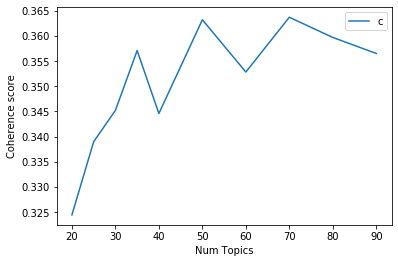

In [64]:
# plot graph
x = [20,25,30,35,40,50,60,70,80,90]
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [65]:
# Print the coherence scores for each number of topic
for m, cv in zip(x, coherence_values):
    print("Number of Topics =", m, " has Coherence Value of", round(cv, 4))

Number of Topics = 20  has Coherence Value of 0.3244
Number of Topics = 25  has Coherence Value of 0.339
Number of Topics = 30  has Coherence Value of 0.3452
Number of Topics = 35  has Coherence Value of 0.3571
Number of Topics = 40  has Coherence Value of 0.3446
Number of Topics = 50  has Coherence Value of 0.3632
Number of Topics = 60  has Coherence Value of 0.3528
Number of Topics = 70  has Coherence Value of 0.3637
Number of Topics = 80  has Coherence Value of 0.3597
Number of Topics = 90  has Coherence Value of 0.3565


**Here we will take 70 as final number of topic as it hase highest coherence value**

In [66]:
final_lda_model = model_list[7] # in list we have70 at 7th position

In [67]:
model_topics = final_lda_model.show_topics(formatted=False)

pprint(final_lda_model.print_topics(num_words=10))

[(44,
  '0.144*"fund" + 0.094*"job" + 0.088*"cut" + 0.077*"boost" + 0.072*"budget" + '
  '0.047*"govern" + 0.042*"feder" + 0.029*"cost" + 0.026*"announc" + '
  '0.023*"promis"'),
 (65,
  '0.090*"market" + 0.062*"share" + 0.057*"fall" + 0.040*"australian" + '
  '0.032*"profit" + 0.030*"street" + 0.027*"post" + 0.026*"dollar" + '
  '0.026*"local" + 0.023*"bank"'),
 (28,
  '0.152*"year" + 0.081*"time" + 0.034*"canberra" + 0.032*"million" + '
  '0.025*"end" + 0.024*"perth" + 0.024*"collaps" + 0.021*"celebr" + '
  '0.019*"build" + 0.019*"tough"'),
 (10,
  '0.095*"power" + 0.051*"station" + 0.046*"ga" + 0.039*"plant" + 0.039*"site" '
  '+ 0.030*"energi" + 0.030*"dump" + 0.030*"hill" + 0.028*"gener" + '
  '0.028*"nuclear"'),
 (29,
  '0.053*"launch" + 0.049*"campaign" + 0.041*"terror" + 0.035*"anti" + '
  '0.031*"target" + 0.021*"ad" + 0.019*"tv" + 0.019*"british" + 0.018*"tri" + '
  '0.018*"move"'),
 (41,
  '0.055*"studi" + 0.046*"research" + 0.038*"cancer" + 0.032*"risk" + '
  '0.026*"find" 

KeyError: 'Terms per Topic'